## Cargo la landsea mask del present day 

In [1]:
# 1- Load libraries
import os
import xarray as xr
import numpy as np
from cdo import Cdo
from utils import modify_single_grib, truncate_grib_file, nullify_grib
from utils import modify_value, replace_value, function_albedo
from utils import extract_grid_info, spectral2gaussian
import shutil
import tempfile
from utils import GRIB2, NC4
cdo = Cdo()

In [2]:
# 2- Load paths
#Input files
icmcl_file = "/home/ecme3497/hpcperm/ece4-database/oifs/TL63L31/climate.v020/ICMCLECE4"
icmgg_file = "/home/ecme3497/hpcperm/ece4-database/oifs/TL63L31/19900101/ICMGGECE4INIT"

#Temp files
icmcl_remap = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc"
icmgg_remap = "/home/ecme3497/hpcperm/ece4-database-eoc/oifs/TL63L31/19900101/ICMGGECE4INIT_remap.nc"

#Output file
outfile = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_eoc_deepmip_new.nc"


In [3]:
# 3- Grid configuration
resolution = "TL63L31"
kind, spectral, _ = extract_grid_info(resolution)
gaussian = spectral2gaussian(spectral, kind)

# 4- Transform GRIB to NetCDF
for infile, outfile in [(icmcl_file,
                         icmcl_remap), 
                         (icmgg_file,
                          icmgg_remap)]:
    if os.path.exists(outfile):
        os.remove(outfile)
    cdo.remapnn(
        f"N{gaussian}",
        input=f"-setgridtype,regular {infile}",
        output=outfile,
        options="-f nc4"
    )


In [4]:
# 5- Abro el archivo icmcl remapeado 
icmcl_remap = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc") 

# Mostrar información general 
print(icmcl_remap)

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 12, lon: 128, lat: 64)
Coordinates:
  * time     (time) object 96B 9999-01-15 00:00:00 ... 9999-12-15 00:00:00
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Data variables:
    al       (time, lat, lon) float32 393kB ...
    aluvp    (time, lat, lon) float32 393kB ...
    aluvd    (time, lat, lon) float32 393kB ...
    alnip    (time, lat, lon) float32 393kB ...
    alnid    (time, lat, lon) float32 393kB ...
    lai_lv   (time, lat, lon) float32 393kB ...
    lai_hv   (time, lat, lon) float32 393kB ...
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Mon Oct 20 12:38:03 2025: cdo -O -s -f nc4 -remapnn,N32 -se...
    CDO:          Climate Data Operators version 2.5.0 (https:

/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.2672763.20251020_122407.023/ipykernel_2685006/2684189018.py:2: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  icmcl_remap = xr.open_dataset("/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_remap.nc")


In [5]:
# 6- Transformo el archivo icmgg de grib a netcdf (para la landsea mask actual)


if os.path.exists(icmgg_remap): 
    os.remove(icmgg_remap) 
cdo.remapnn( 
    f"N{gaussian}", 
    input=f"-setgridtype,regular {icmgg_file}", 
    output=icmgg_remap, 
    options='-f nc4' 
    )

'/home/ecme3497/hpcperm/ece4-database-eoc/oifs/TL63L31/19900101/ICMGGECE4INIT_remap.nc'

In [6]:
# 7- Abro el archivo icmgg remapeado 
icmgg_remap = xr.open_dataset("/home/ecme3497/hpcperm/ece4-database-eoc/oifs/TL63L31/19900101/ICMGGECE4INIT_remap.nc") 

# Mostrar información general 
print(icmgg_remap)

<xarray.Dataset> Size: 3MB
Dimensions:       (time: 1, lon: 128, lat: 64, snow: 5, bnds: 2, depth: 1,
                   depth_2: 1, depth_3: 1, depth_4: 1)
Coordinates:
  * time          (time) datetime64[ns] 8B 1990-01-01
  * lon           (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lat           (lat) float64 512B 87.86 85.1 82.31 ... -82.31 -85.1 -87.86
  * snow          (snow) float64 40B 0.0 1.0 2.0 3.0 4.0
  * depth         (depth) float64 8B 0.0
  * depth_2       (depth_2) float64 8B 7.0
  * depth_3       (depth_3) float64 8B 28.0
  * depth_4       (depth_4) float64 8B 100.0
Dimensions without coordinates: bnds
Data variables: (12/65)
    snow_bnds     (snow, bnds) float64 80B ...
    depth_bnds    (depth, bnds) float64 16B ...
    depth_2_bnds  (depth_2, bnds) float64 16B ...
    depth_3_bnds  (depth_3, bnds) float64 16B ...
    depth_4_bnds  (depth_4, bnds) float64 16B ...
    asn           (time, snow, lat, lon) float32 164kB ...
    ...            ...


NameError: name 'plt' is not defined

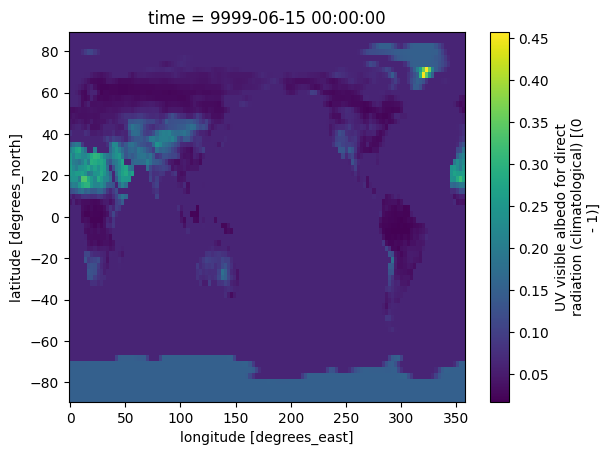

In [7]:
icmcl_remap['aluvp'].isel(time=5).plot(cmap='viridis')

plt.title("aluvp masked (time=0)")
plt.show()

In [8]:
# Ver variables disponibles 
print(icmgg_remap.data_vars) 

# Ver dimensiones
print(icmgg_remap.dims)

Data variables:
    snow_bnds     (snow, bnds) float64 80B ...
    depth_bnds    (depth, bnds) float64 16B ...
    depth_2_bnds  (depth_2, bnds) float64 16B ...
    depth_3_bnds  (depth_3, bnds) float64 16B ...
    depth_4_bnds  (depth_4, bnds) float64 16B ...
    asn           (time, snow, lat, lon) float32 164kB ...
    stl1          (time, depth, lat, lon) float32 33kB ...
    stl2          (time, depth_2, lat, lon) float32 33kB ...
    stl3          (time, depth_3, lat, lon) float32 33kB ...
    stl4          (time, depth_4, lat, lon) float32 33kB ...
    swvl1         (time, depth, lat, lon) float32 33kB ...
    swvl2         (time, depth_2, lat, lon) float32 33kB ...
    swvl3         (time, depth_3, lat, lon) float32 33kB ...
    swvl4         (time, depth_4, lat, lon) float32 33kB ...
    src           (time, lat, lon) float32 33kB ...
    skt           (time, lat, lon) float32 33kB ...
    ci            (time, lat, lon) float32 33kB ...
    lmlt          (time, lat, lon) float

In [9]:
# 8- Extraigo el landsea mask actual y elimino las dimensiones que no me sirven. Dejo solo lat y lon.
lsm = icmgg_remap["lsm"].isel(time=0).squeeze() 

In [10]:
lsm

<xarray.DataArray 'lsm' (lat: 64, lon: 128)> Size: 33kB
[8192 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 1990-01-01
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Attributes:
    standard_name:     land_binary_mask
    long_name:         Land-sea mask
    units:             (0 - 1)
    code:              172
    table:             128
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  32

In [11]:
# 9- Expando la landsea mask actual a las dimensiones del archivo icmcl_recap
lsm_exp = lsm.broadcast_like(icmcl_remap)>0.5  # ahora tiene (time=12, lat=96, lon=192)

In [11]:
# 10- Creo una mascara para land
land_mask = lsm_exp > 0.5 

In [17]:
# 11- Aplico la mascara de tierra al archivo icmcl
icmcl_masked = icmcl_remap.where(lsm_exp, np.nan)


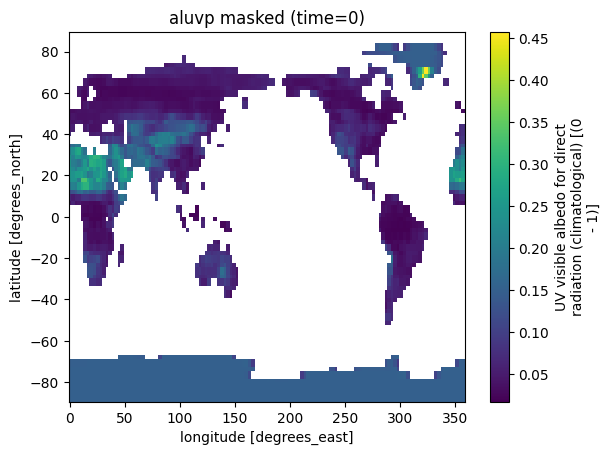

In [18]:
icmcl_masked['aluvp'].isel(time=5).plot(cmap='viridis')

plt.title("aluvp masked (time=0)")
plt.show()

In [14]:
# 12- Calculo media zonal y relleno NaNs en latitudes sin tierra
zonal_mean = icmcl_masked.mean(dim="lon", skipna=True)

# Reordenar para que lat vaya de sur (-90) a norte (+90)
zonal_mean_sorted = zonal_mean.sortby("lat")

# Interpolar valores faltantes
zonal_mean_filled = zonal_mean_sorted.interpolate_na(dim="lat", method="nearest")

# (Si necesitas volver al orden original norte→sur)
zonal_mean_filled = zonal_mean_filled.sortby("lat", ascending=False)


In [15]:
zonal_mean_filled

<xarray.Dataset> Size: 33kB
Dimensions:  (time: 12, lat: 96)
Coordinates:
  * time     (time) object 96B 9999-01-15 00:00:00 ... 9999-12-15 00:00:00
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Data variables:
    al       (time, lat) float32 5kB nan nan nan 0.15 ... 0.15 0.15 0.15 0.15
    aluvp    (time, lat) float32 5kB nan nan nan 0.1335 ... 0.15 0.15 0.15 0.15
    aluvd    (time, lat) float32 5kB nan nan nan 0.1335 ... 0.15 0.15 0.15 0.15
    alnip    (time, lat) float32 5kB nan nan nan 0.1335 ... 0.15 0.15 0.15 0.15
    alnid    (time, lat) float32 5kB nan nan nan 0.1335 ... 0.15 0.15 0.15 0.15
    lai_lv   (time, lat) float32 5kB nan nan nan 0.3085 ... 0.0 0.0 0.0 0.0
    lai_hv   (time, lat) float32 5kB nan nan nan 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [16]:
# 13- Reconstruyo 2D a partir de la media zonal 
lat = icmcl_masked["lat"] 
lon = icmcl_masked["lon"] 
reconstructed = xr.Dataset() 
for var in icmcl_masked.data_vars: 
    if var not in zonal_mean: 
        print(f"Variable {var} no está en el promedio zonal. Se omite.") 
        continue 
    print(f"Procesando: {var}") 
    data = zonal_mean[var].expand_dims({"lon": lon}) 
    
    if data.ndim == 3: 
        reconstructed[var] = data.transpose("time", "lat", "lon") 
    elif data.ndim == 2: 
        reconstructed[var] = data.transpose("lat", "lon") 

Procesando: al
Procesando: aluvp
Procesando: aluvd
Procesando: alnip
Procesando: alnid
Procesando: lai_lv
Procesando: lai_hv


## Hasta aca va todo mas o menos bien. 
El problema que tengo es que tengo estas latitudes con NaN:
* 88.57216851  
* 86.72253095  
* 84.86197029 
* -53.15959537 
* -55.02480754
* -56.8900126  
* -58.75520927 
* -60.62039593 
* -62.48557052 
* -64.35073041
* -66.21587211

Necesito ver como hago para calcular un promedio para los valores a los 80ºN y a los 45ºS de latitud, y extrapolar esos valores hacia el norte y hacia el sur.

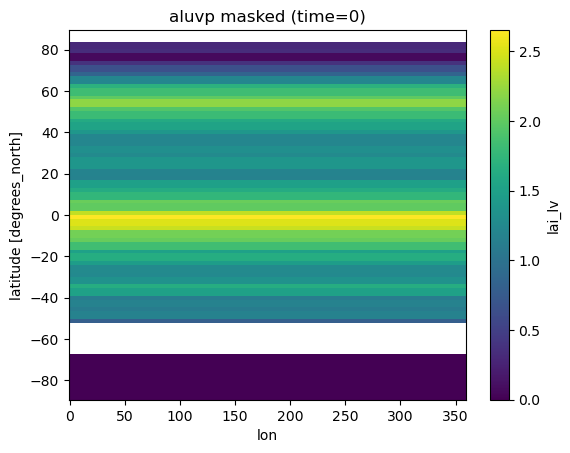

In [17]:
reconstructed['lai_lv'].isel(time=5).plot(cmap='viridis')

plt.title("aluvp masked (time=0)")
plt.show()

In [18]:
# 14- Creo mascaras para las bandas polares con albedos no glaciales
lat = reconstructed["lat"]
band_mask_s = (lat >= -52) & (lat <= -46)   # independiente de si lat está en orden N→S o S→N
band_mask_n = (lat >= 70) & (lat <= 75)   # independiente de si lat está en orden N→S o S→N


In [20]:
band_mask_n

<xarray.DataArray 'lat' (lat: 96)> Size: 96B
array([False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])
Coordinates:
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57

In [ ]:
# 15- Aplico la mascara para 
#la banda norte
band_n = reconstructed.sel(lat=lat.where(band_mask_n, drop=True))

#la banda sur
band_s = reconstructed.sel(lat=lat.where(band_mask_s, drop=True))

In [20]:
# 16- Calculo el promedio espacial sobre lat y lon ---
# Resultado: Dataset con dims (time,) para cada variable, 
# Para la banda norte
mean_band_n = band_n.mean(dim=("lat", "lon"), skipna=True)

# Para la banda sur
mean_band_s = band_s.mean(dim=("lat", "lon"), skipna=True)


In [21]:
# 17- Creo una mascara para 
# las latitudes al sur de -52ºS 
south_mask = (lat < -52)
# las latitudes al norte de los 75ºN
north_mask = (lat > 75)

In [22]:
# 18- Relleno las latitudes australes con el promedio ---
# Broadcasting: (time,) -> se expande sobre lat y lon
mask_da_s = xr.DataArray(south_mask, dims=["lat"], coords={"lat": lat})
reconstructed_filled = reconstructed.where(~mask_da_s, other=mean_band_s)

In [23]:
# 19- Relleno las latitudes boreales con el promedio ---
# Broadcasting: (time,) -> se expande sobre lat y lon
mask_da_n = xr.DataArray(north_mask, dims=["lat"], coords={"lat": lat})
reconstructed_filled_n = reconstructed_filled.where(~mask_da_n, other=mean_band_n)

In [24]:
# 20- Reemplazo el dataset original 
icmcl_remap = reconstructed_filled_n

print("Latitudes modificadas:", lat.where(south_mask, drop=True).values)

Latitudes modificadas: [-53.15959537 -55.02480754 -56.8900126  -58.75520927 -60.62039593
 -62.48557052 -64.35073041 -66.21587211 -68.08099099 -69.94608065
 -71.81113211 -73.67613231 -75.54106145 -77.40588808 -79.27055903
 -81.13497684 -82.99894164 -84.86197029 -86.72253095 -88.57216851]


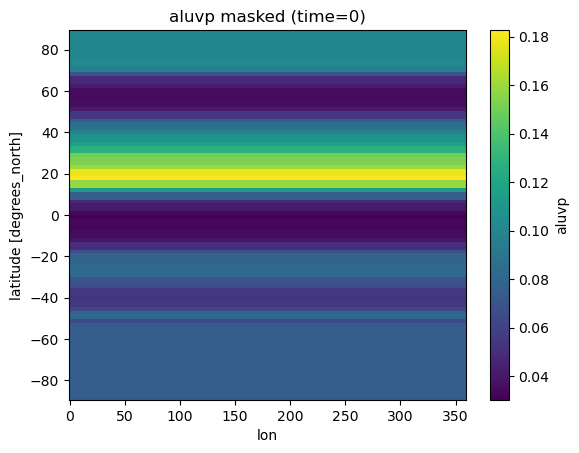

In [25]:
icmcl_remap['aluvp'].isel(time=5).plot(cmap='viridis')

plt.title("aluvp masked (time=0)")
plt.show()

# Hasta aca vamos joya. Logre corregir los valores polares
Ahora tengo que aplicar la mascara del eoceno, y ponerle un valor constante de 0,5 de albedo al oceano.

# Probando desde aca

In [3]:
# 3- Cargo la ruta para la landsea mask del eoceno
eocene = EoceneOIFS(
    idir="/lus/h2resw01/hpcperm//ecme3497/ece4-database",
    odir="/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc",
    herold="/lus/h2resw01/hpcperm/ecme3497/herold-et-al-2014/Supp"
)

landsea_remap_path = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/landsea_eoc_remap.nc"

In [26]:
# 21- Guardar landsea_eoc como archivo temporal ---
landsea_eoc = xr.open_dataset(eocene.prepare_herold(flag="landsea_mask"))

with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
    landsea_path = tmp.name
    landsea_eoc.to_netcdf(landsea_path)

In [27]:
# 22- Definir archivo temporal de salida ---
with tempfile.NamedTemporaryFile(suffix=".nc", delete=False) as tmp:
    landsea_remap_path = tmp.name

In [28]:
# 23- Remapear a la grilla N48 (96×192) ---
cdo.remapnn(
    f"N{gaussian}",   # archivo con la grilla target
    input=landsea_path, 
    output=landsea_remap_path,
    options="-f nc4"
)

'/etc/ecmwf/ssd/ssd1/tmpdirs/ecme3497.1230251.20250912_081137.303/tmpgrpwvzlz.nc'

In [ ]:
# 24- Abrir resultado ---
landsea_on_icmcl = xr.open_dataset(landsea_remap_path)

In [40]:
# 25- Crear máscara booleana ---
mask_var_eoc = list(landsea_on_icmcl.data_vars)[0]   # debería ser "mask" o similar
lsm = landsea_on_icmcl[mask_var_eoc] > 0.5

In [41]:
# 26- Expandir máscara a dimensiones de icmcl_remap ---
mask_exp_eoc = lsm.broadcast_like(icmcl_remap)

In [42]:
# 27- Aplicar máscara a icmcl_remap ---
icmcl_masked_eoc = icmcl_remap.where(mask_exp_eoc, np.nan)

In [43]:
icmcl_masked_eoc

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 12, lat: 96, lon: 192)
Coordinates:
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time     (time) object 96B 9999-01-15 00:00:00 ... 9999-12-15 00:00:00
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Data variables:
    al       (time, lat, lon) float32 885kB nan nan nan ... 0.1408 0.1408 0.1408
    aluvp    (time, lat, lon) float32 885kB nan nan nan ... 0.07559 0.07559
    aluvd    (time, lat, lon) float32 885kB nan nan nan ... 0.08134 0.08134
    alnip    (time, lat, lon) float32 885kB nan nan nan ... 0.1527 0.1527 0.1527
    alnid    (time, lat, lon) float32 885kB nan nan nan ... 0.1692 0.1692 0.1692
    lai_lv   (time, lat, lon) float32 885kB nan nan nan ... 0.9957 0.9957 0.9957
    lai_hv   (time, lat, lon) float32 885kB nan nan nan ... 2.614 2.614 2.614

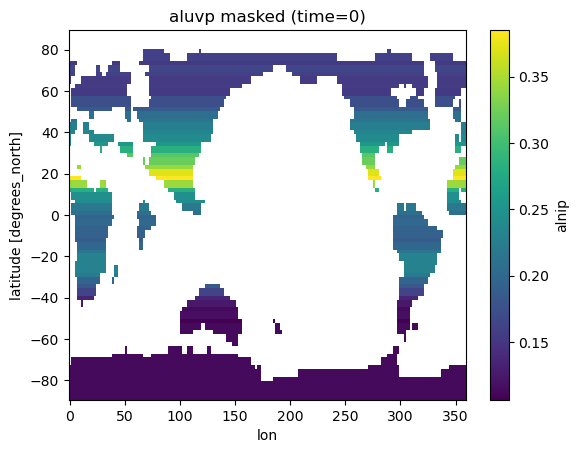

In [44]:
icmcl_masked_eoc['alnip'].isel(time=5).plot(cmap='viridis')

plt.title("aluvp masked (time=0)")
plt.show()

In [45]:
# 28- Lista de variables
albedo_vars = ['al', 'aluvp', 'aluvd', 'alnip', 'alnid']
lai_vars = ['lai_lv', 'lai_hv']

# 29- Recorremos las variables de albedo y reemplazamos NaN del océano por 0.05
icmcl_masked_eoc[albedo_vars] = icmcl_masked_eoc[albedo_vars].where(mask_exp_eoc, 0.05)
icmcl_masked_eoc[lai_vars] = icmcl_masked_eoc[lai_vars].where(mask_exp_eoc)

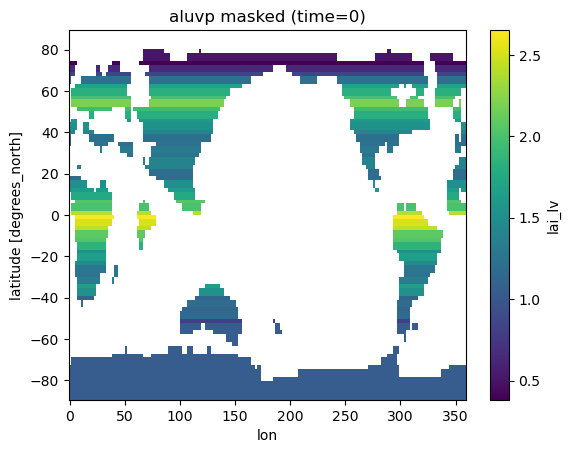

In [46]:
icmcl_masked_eoc['lai_lv'].isel(time=5).plot(cmap='viridis')

plt.title("aluvp masked (time=0)")
plt.show()

# Volver a convertir todo al archivo original, pasar a eocene_creator

In [ ]:



        
# --- 6. Guardar archivo NetCDF 
output_file = "/lus/h2resw01/hpcperm/ecme3497/ece4-database-eoc/oifs/TL63L31/climate.v020/ICMCLECE4_eoc_deepmip.nc" 
reconstructed.to_netcdf(output_file) 
print(f"✅ Archivo guardado en: {output_file}")